<a href="https://colab.research.google.com/github/izzul112/Submission-Time_Series/blob/master/Submission_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('daily-min-temperatures.csv')
data_train.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
data_train.isnull().sum()

Date    0
Temp    0
dtype: int64

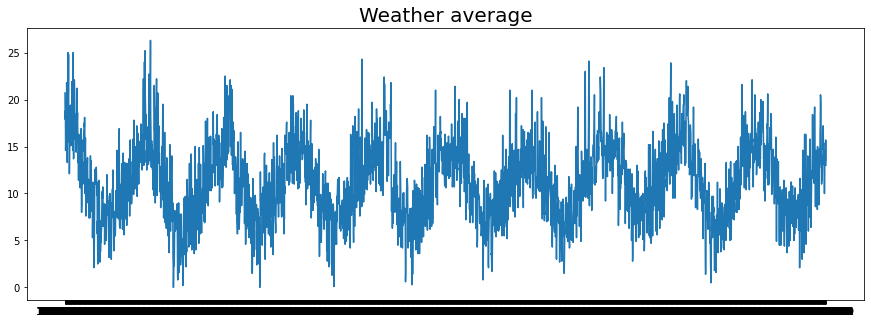

In [4]:
dates = data_train['Date'].values
temp  = data_train['Temp'].values
 
dates = np.array(dates)
temp = np.array(temp)
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Weather average',
          fontsize=20);

In [5]:
split_time = int(len(dates)*0.8)
time_train = dates[:split_time]
x_train = temp[:split_time]
time_valid = dates[split_time:]
x_valid = temp[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, temp, window_size):
    ds = tf.data.Dataset.from_tensor_slices(temp)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(-1)
    forecast = model.predict(ds)
    return forecast

In [8]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [9]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data=val_set)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 9s 567ms/step - loss: 10.4746 - mae: 10.9737 - val_loss: 10.4976 - val_mae: 10.9974
Epoch 2/100
15/15 [==============================] - 7s 462ms/step - loss: 10.3983 - mae: 10.8974 - val_loss: 10.4130 - val_mae: 10.9127
Epoch 3/100
15/15 [==============================] - 7s 452ms/step - loss: 10.3221 - mae: 10.8211 - val_loss: 10.3406 - val_mae: 10.8403
Epoch 4/100
15/15 [==============================] - 7s 455ms/step - loss: 10.2502 - mae: 10.7491

In [10]:
rnn_forecast = model_forecast(model, temp[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

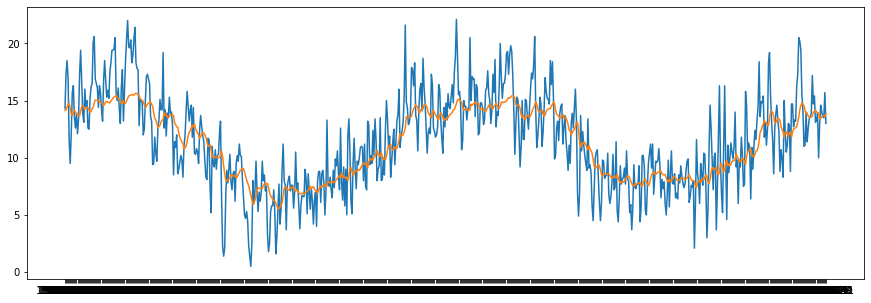

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.show()